### OCI Data Science - Useful Tips
Everything stored in the <span style="background-color: #d5d8dc ">/home/datascience</span> folder is now stored on your block volume drive. The <span style="background-color: #d5d8dc ">ads-examples</span> folder has moved outside of your working space. Notebook examples are now accessible through a Launcher tab "Notebook Examples" button.
<details>
<summary><font size="2">1. Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">2. OCI Configuration and Key Files Set Up</font></summary><p>Follow the instructions in the getting-started notebook. That notebook is accessible via the "Getting Started" Launcher tab button.</p>
</details>
<details>
<summary><font size="2">3. Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">4. Typical Cell Imports and Settings</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import MLData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">5. Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [190]:
import sys
sys.path.append("/home/datascience/footballer_valuation/footballer_valuation/python/extractions/")
import sqlalchemy as db
import pandas as pd
import numpy as np
import os
import warnings as w
from Connection import Connection
from PlayerTMarkt import PlayerTMarkt
from Player import Player
from PlayerStats import PlayerStats
from Utils import Utils
import logging
import json
import requests
import sqlalchemy as db
import warnings as w
import os
import re
from sqlalchemy import (MetaData, Table, Column, Integer,Float,Date, select, literal, and_, exists,String)
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm import relationship
from datetime import datetime
from multiprocessing import Pool
import unidecode
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import get_scorer

w.filterwarnings("ignore",category=Warning)

os.environ['TNS_ADMIN']='/home/datascience/instantclient_19_5/network/admin/'
engine = db.create_engine('oracle://<user>:<password>@dbml19c_high')


In [191]:
from ads.automl.driver import AutoML
from ads.automl.provider import OracleAutoMLProvider
from ads.catalog.model import ModelCatalog
from ads.catalog.project import ProjectCatalog
from ads.common.model_artifact import ModelArtifact
from ads.common.data import MLData
from ads.common.model import ADSModel
from ads.dataset.factory import DatasetFactory
from ads.evaluations.evaluator import ADSEvaluator
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer

In [192]:
con = Connection("mycon","oracle",20,"utf-8")
sql="""SELECT
    team_id,
    captain,
    game_appearences,
    games_minutes_played,
    games_lineups,
    substitutes_in,
    substitutes_out,
    substitutes_bench,
    goals_total,
    assists,
    conceded,
    saves,
    passes_total,
    key_pass,
    pass_accuracy,
    tackles_total,
    tackles_blocks,
    tackles_interceptions,
    duels_total,
    duels_won,
    dribbles_attempts,
    dribbles_success,
    fouls_drawn,
    fouls_commited,
    shots_total,
    shots_on,
    penalty_won,
    penalty_commited,
    penalty_success,
    penalty_missed,
    penalty_saved,
    yellow_card,
    yellowred,
    red_card,
    position,
    nationality,
    age,
    height,
    weight,
   lsispl lastSeasonPL,
    lsstats lastSeasonStats,
    plex plExperience,
    sumteamexp teamTenure,
    gpmdiffer statsChange,
    last3SeasonTeamChange,
    target1
FROM
    stg_dataset_premier_league"""
sess = con.create_oracle_session()

In [193]:
#encoding
df = pd.read_sql(con=con.engine,sql=sql)
df['position'] = df['position'].astype('category')
df['position_cat'] = df['position'].cat.codes
df = df.drop('position', 1)
#encoding
df['nationality'] = df['nationality'].astype('category')
df['nationality_cat'] = df['nationality'].cat.codes
df = df.drop('nationality', 1)
#bining
df["games_lineups_cat"] = pd.cut(df["games_lineups"],10, precision=0, labels=[1,2,3,4,5,6,7,8,9,10])
df = df.drop('games_lineups', 1)
#pd.qcut(df["games_lineups"],10, duplicates="drop").value_counts()

In [194]:
adf = DatasetFactory.from_dataframe(df).set_target('target1')

In [195]:
adf.columns

Index(['team_id', 'captain', 'game_appearences', 'games_minutes_played',
       'substitutes_in', 'substitutes_out', 'substitutes_bench', 'goals_total',
       'assists', 'conceded', 'saves', 'passes_total', 'key_pass',
       'pass_accuracy', 'tackles_total', 'tackles_blocks',
       'tackles_interceptions', 'duels_total', 'duels_won',
       'dribbles_attempts', 'dribbles_success', 'fouls_drawn',
       'fouls_commited', 'shots_total', 'shots_on', 'penalty_won',
       'penalty_commited', 'penalty_success', 'penalty_missed',
       'penalty_saved', 'yellow_card', 'yellowred', 'red_card', 'age',
       'height', 'weight', 'lastseasonpl', 'lastseasonstats', 'plexperience',
       'teamtenure', 'statschange', 'last3seasonteamchange', 'target1',
       'position_cat', 'nationality_cat', 'games_lineups_cat'],
      dtype='object')

In [274]:
adf.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: BinaryClassificationDataset</h3><h3>5,446 Rows, 46 Columns</h3><h4>C…

In [196]:
adf.type_of_target()

{
  "type": "categorical",
  "low_level_type": "category",
  "missing_percentage": 0.0,
  "stats": {
    "unique percentage": 0.03672420124862284,
    "mode": 0,
    "count": 5446,
    "unique": 2,
    "top": 0,
    "freq": 3674
  },
  "feature_name": "target1"
}

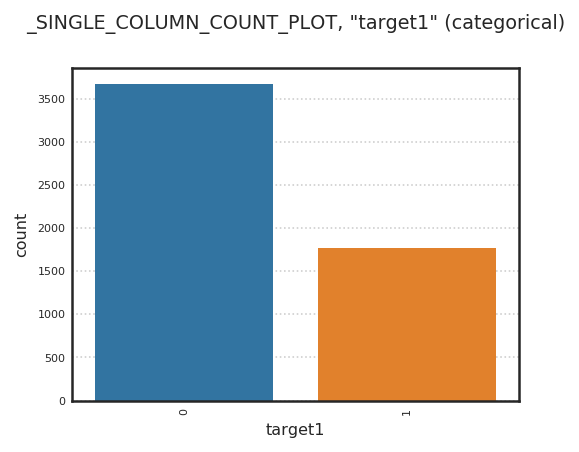

In [197]:
adf.target.show_in_notebook()

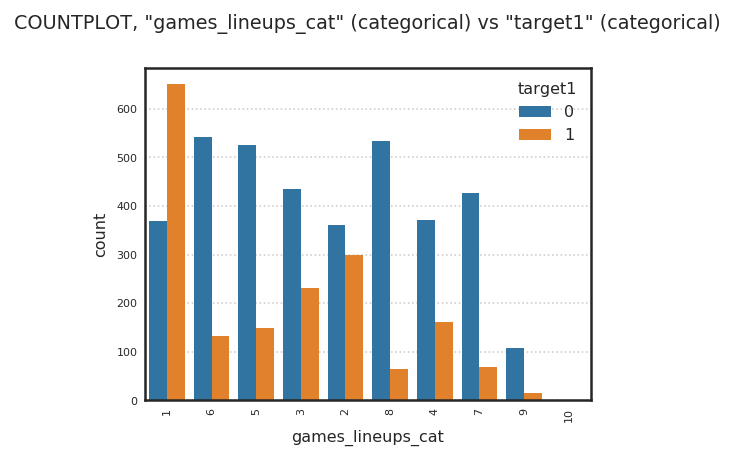

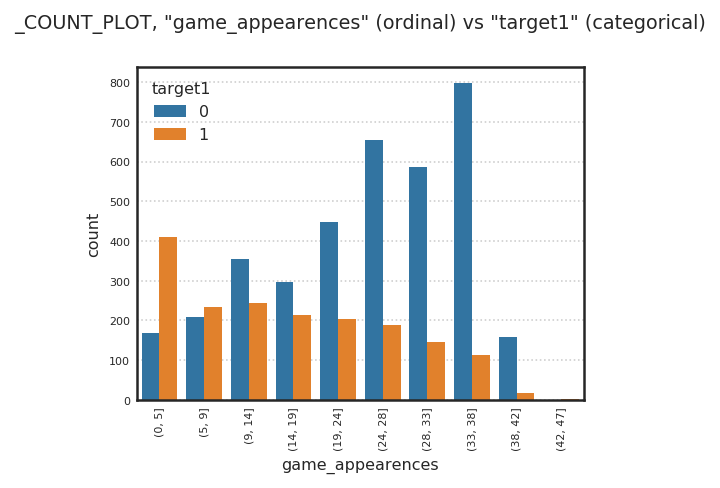

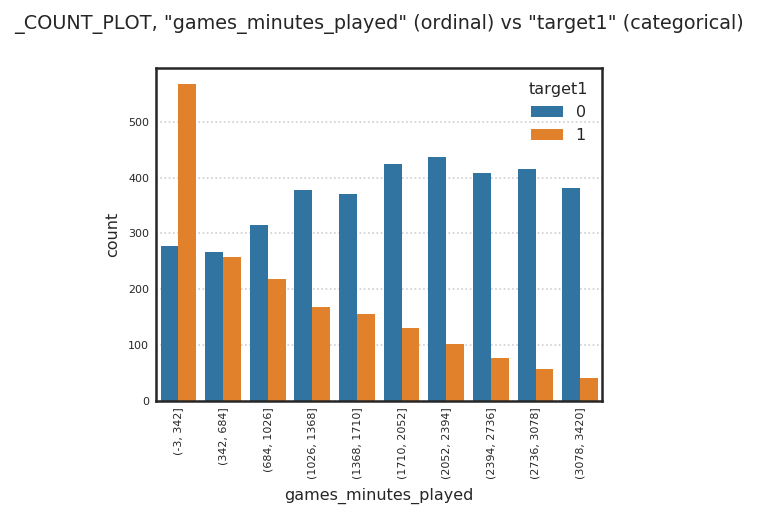

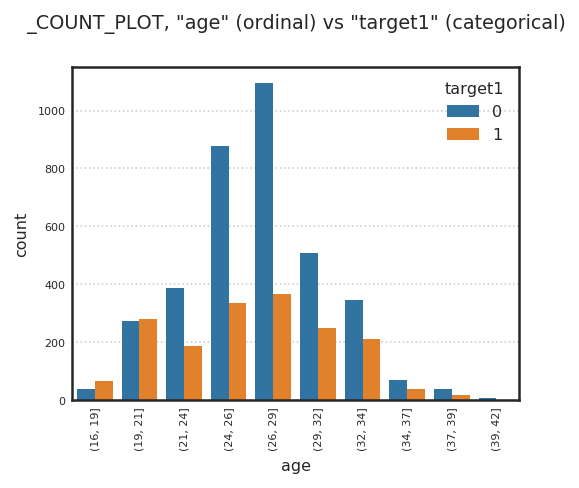

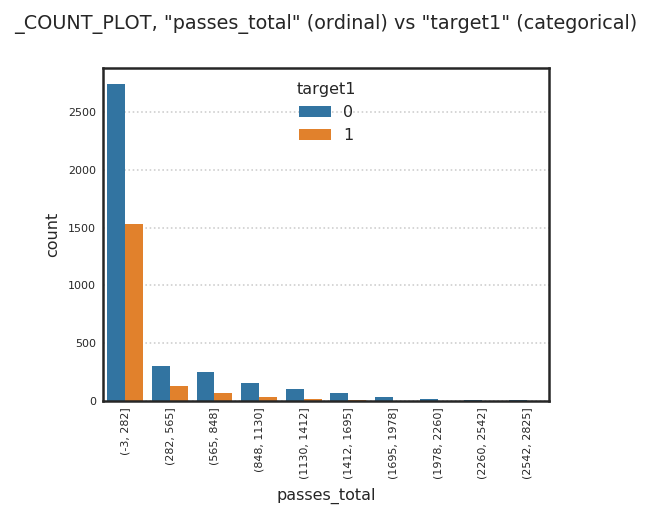

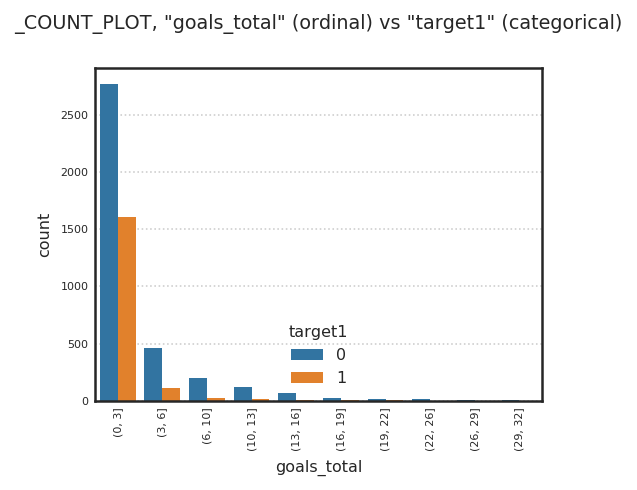

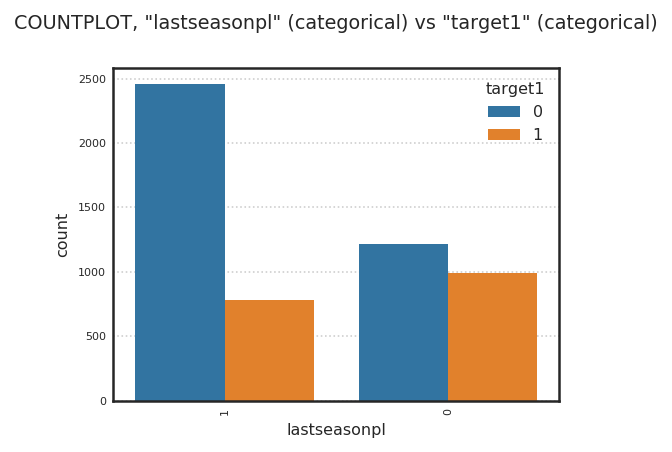

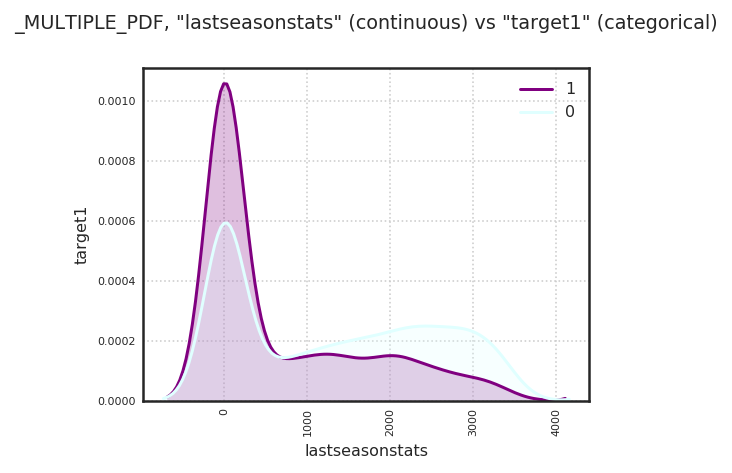

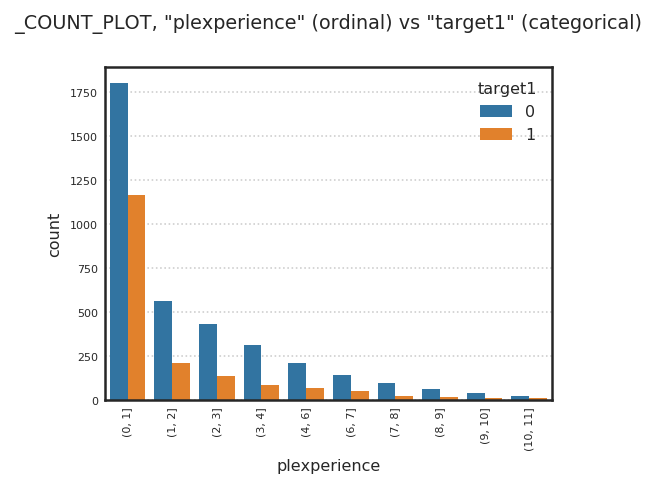

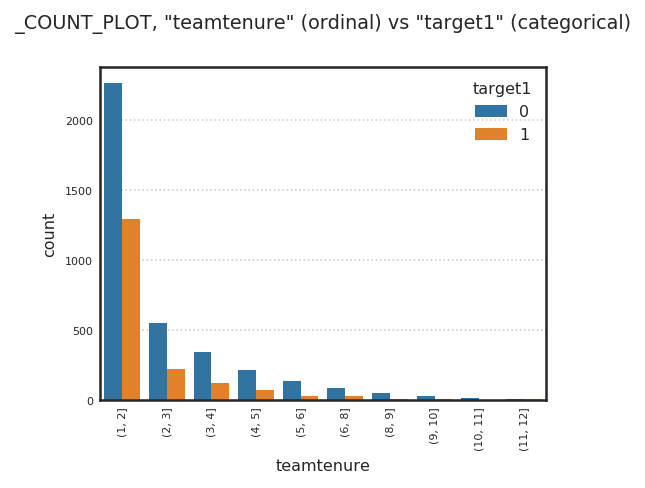

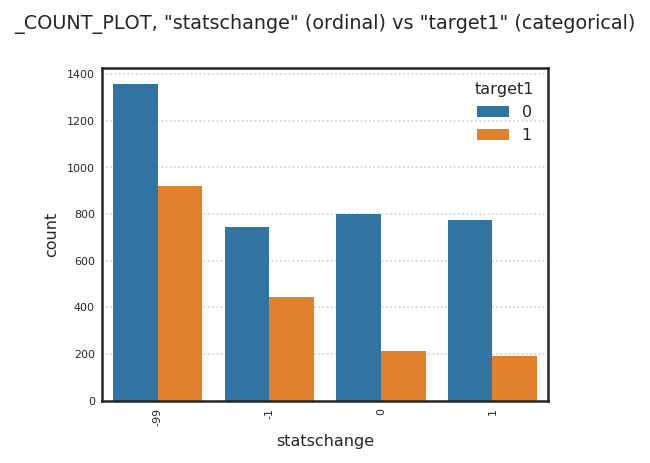

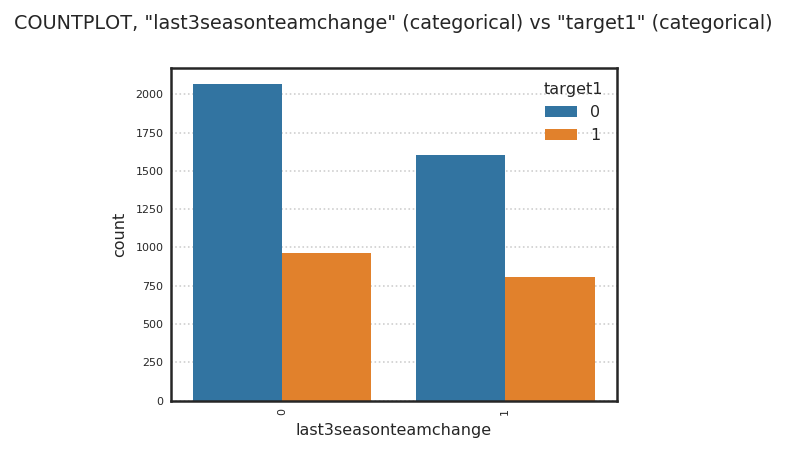

In [198]:
adf.target.show_in_notebook(feature_names=["games_lineups_cat","game_appearences","games_minutes_played","age","passes_total","goals_total","lastseasonpl","lastseasonstats","plexperience","teamtenure","statschange","last3seasonteamchange"])

In [8]:
adf.suggest_recommendations()

KeyboardInterrupt: 

In [199]:
transformed_ds = adf.auto_transform(fix_imbalance=False)
#transformed_ds = adf

In [200]:
modeling_dataset = transformed_ds.select_best_features(k=46)
print(modeling_dataset.columns.values)

['games_minutes_played' 'game_appearences' 'lastseasonstats' 'yellow_card'
 'lastseasonpl' 'goals_total' 'passes_total' 'plexperience'
 'substitutes_out' 'statschange' 'substitutes_bench' 'duels_won'
 'teamtenure' 'key_pass' 'assists' 'tackles_total' 'shots_total'
 'shots_on' 'fouls_drawn' 'dribbles_success' 'tackles_interceptions'
 'fouls_commited' 'tackles_blocks' 'weight' 'team_id' 'age' 'penalty_won'
 'pass_accuracy' 'penalty_success' 'height' 'red_card' 'nationality_cat'
 'captain' 'saves' 'yellowred' 'penalty_missed' 'substitutes_in'
 'position_cat' 'penalty_saved' 'last3seasonteamchange' 'penalty_commited'
 'target1']


In [201]:
train, test = modeling_dataset.train_test_split()
automl = AutoML(train, provider=OracleAutoMLProvider(n_jobs=32))
model, baseline = automl.train(model_list=['AdaBoostClassifier','DecisionTreeClassifier','ExtraTreesClassifier','KNeighborsClassifier','LGBMClassifier','LinearSVC','LogisticRegression','RandomForestClassifier','SVC','XGBClassifier'],random_state = 42, score_metric = "roc_auc", time_budget=300)

Training Dataset size,"(4875, 41)"
Validation Dataset size,None
CV,5
Target variable,target1
Optimization Metric,roc_auc
Initial number of Features,41
Selected number of Features,28
Selected Features,"[games_minutes_played, game_appearences, lastseasonstats, yellow_card, lastseasonpl, goals_total, passes_total, plexperience, substitutes_out, statschange, substitutes_bench, duels_won, teamtenure, key_pass, assists, tackles_total, shots_total, fouls_drawn, tackles_interceptions, fouls_commited, weight, team_id, age, height, nationality_cat, saves, substitutes_in, position_cat]"
Selected Algorithm,LGBMClassifier
End-to-end Elapsed Time (seconds),55.11
Selected Hyperparameters,"{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 101, 'num_leaves': 31, 'reg_alpha': 0.0001778292746984456, 'reg_lambda': 0.9999875000000014}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
2,LGBMClassifier_AS,4875,41,0.8092,"{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 1, 'class_weight': 'balanced'}",2.0234
3,LGBMClassifier_HT,4875,28,0.8056,"{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0.0001778292746984456, 'reg_lambda': 0.9999887500000012}",2.0173
4,LGBMClassifier_HT,4875,28,0.8056,"{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0.0001778292746984456, 'reg_lambda': 0.9999875000000014}",2.5237
5,LGBMClassifier_HT,4875,28,0.8056,"{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0.0001778292746984456, 'reg_lambda': 1}",2.1927
6,LGBMClassifier_HT,4875,28,0.8056,"{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0.00018782927469744562, 'reg_lambda': 1}",2.8127
...,...,...,...,...,...,...
201,LGBMClassifier_HT,4875,28,0.6746,"{'boosting_type': 'dart', 'class_weight': 'balanced', 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 0.0, 'n_estimators': 5, 'num_leaves': 3, 'reg_alpha': 1e-10, 'reg_lambda': 1}",0.0984
202,LGBMClassifier_HT,4875,28,0.6746,"{'boosting_type': 'dart', 'class_weight': 'balanced', 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 0.0, 'n_estimators': 5, 'num_leaves': 3, 'reg_alpha': 1e-10, 'reg_lambda': 0.0031722934713580386}",0.1074
203,LGBMClassifier_HT,4875,28,0.6723,"{'boosting_type': 'dart', 'class_weight': None, 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 0.0, 'n_estimators': 5, 'num_leaves': 3, 'reg_alpha': 1e-10, 'reg_lambda': 1e-10}",0.1183
204,DecisionTreeClassifier_AS,4875,41,0.6609,"{'class_weight': None, 'max_features': 1.0, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",0.3424


In [202]:
accuracy_scorer = get_scorer("accuracy") # works with any sklearn scoring function

print("Oracle AutoML accuracy on test data:", model.score(test.X, test.y, score_fn = accuracy_scorer))

Oracle AutoML accuracy on test data: 0.7740805604203153


In [180]:
model.selected_model_params_

{'C': 0.39616140874190076, 'class_weight': 'balanced', 'solver': 'sag'}

In [181]:
model.ranked_models_

['LogisticRegression']

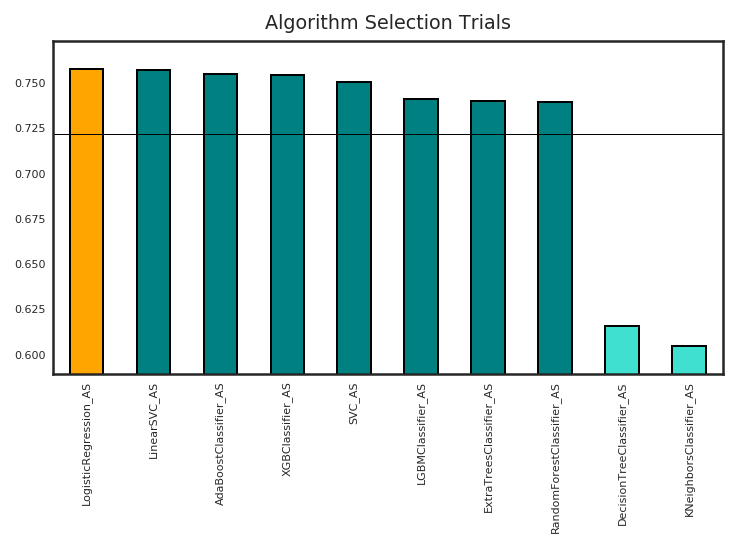

In [182]:
automl.visualize_algorithm_selection_trials()

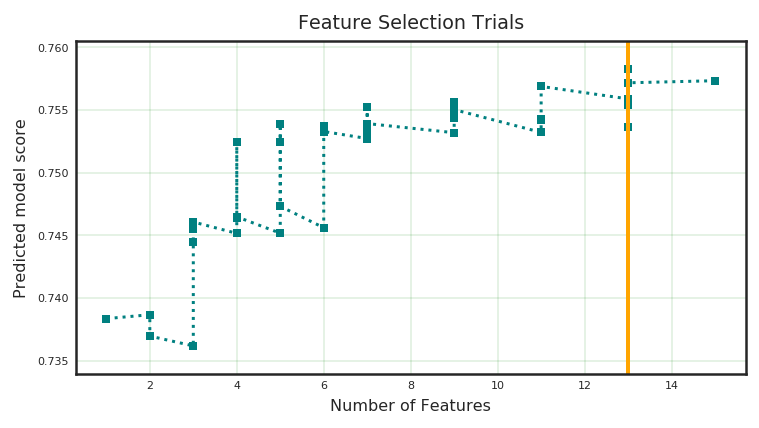

In [183]:
automl.visualize_feature_selection_trials()

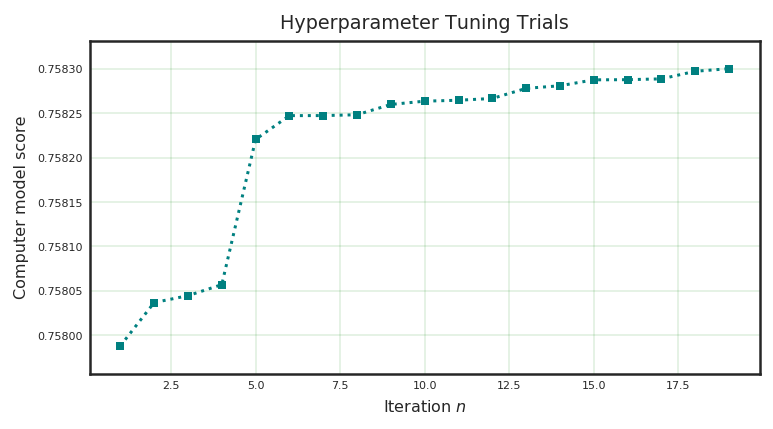

In [184]:
automl.visualize_tuning_trials()

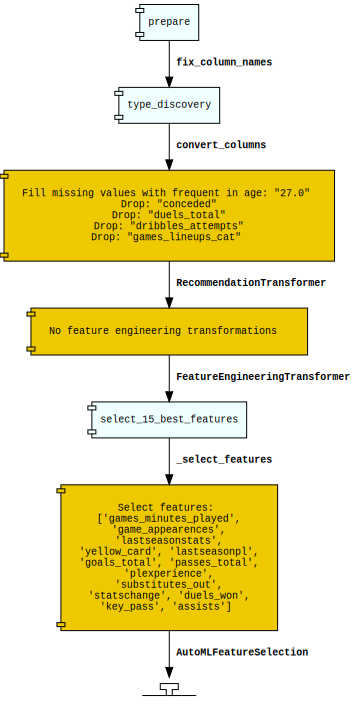

In [185]:
model.visualize_transforms()

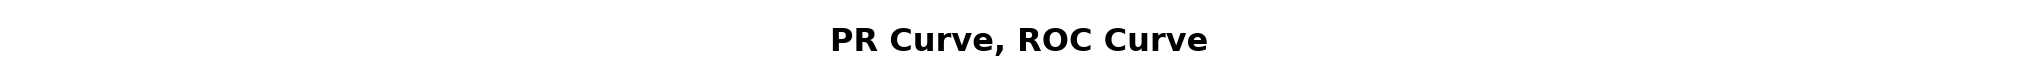

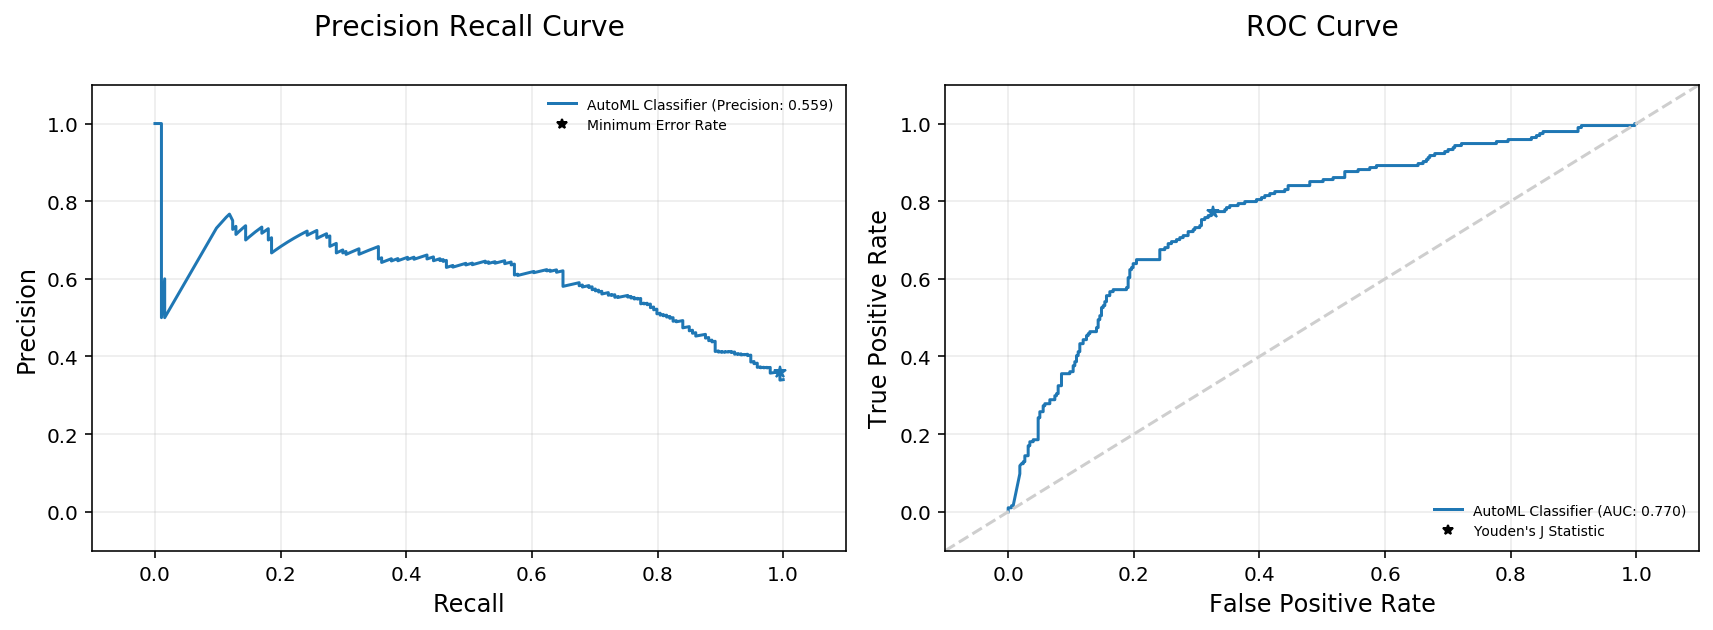

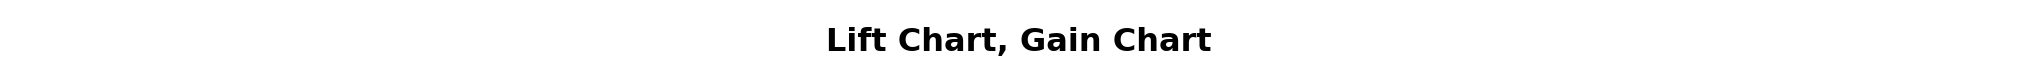

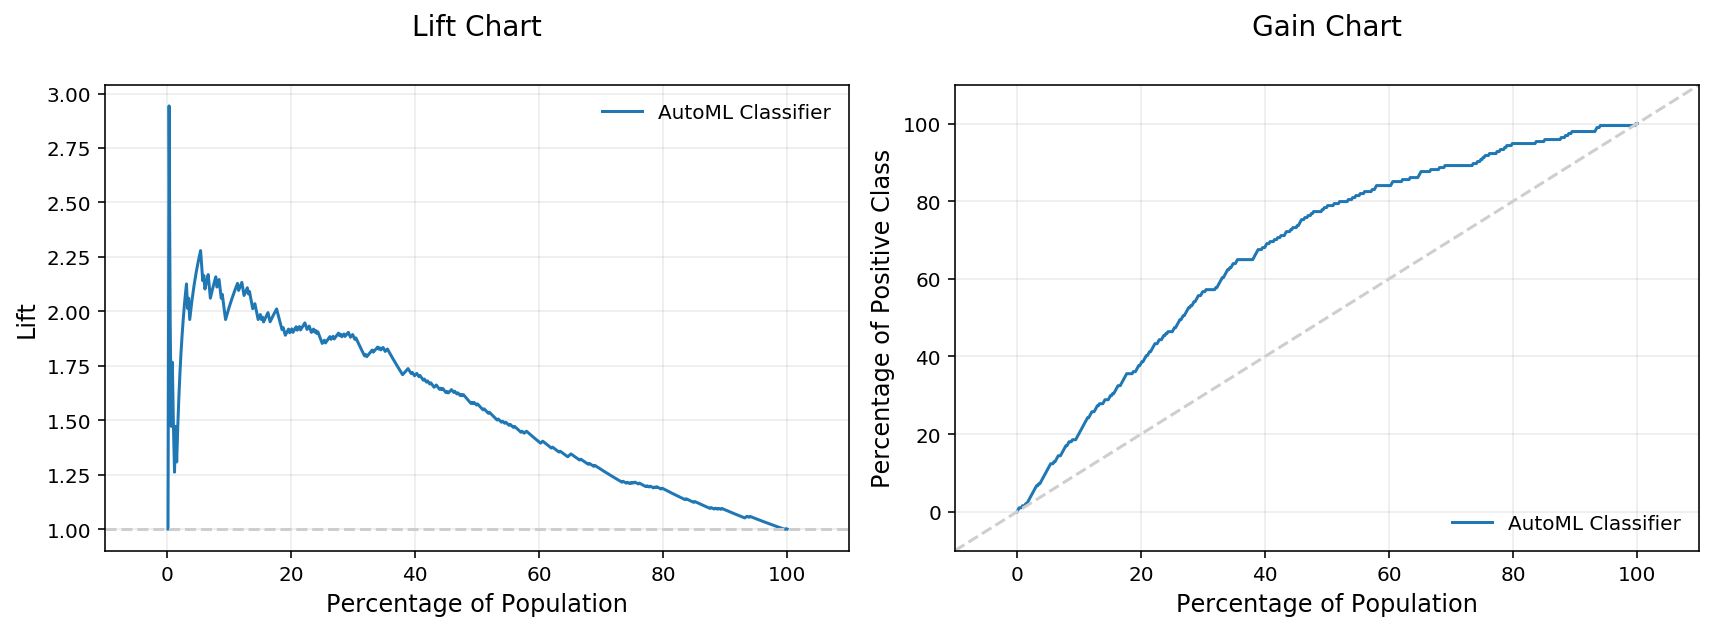

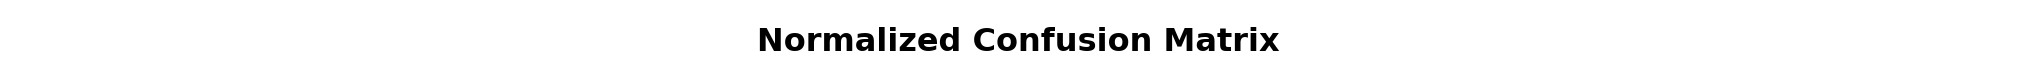

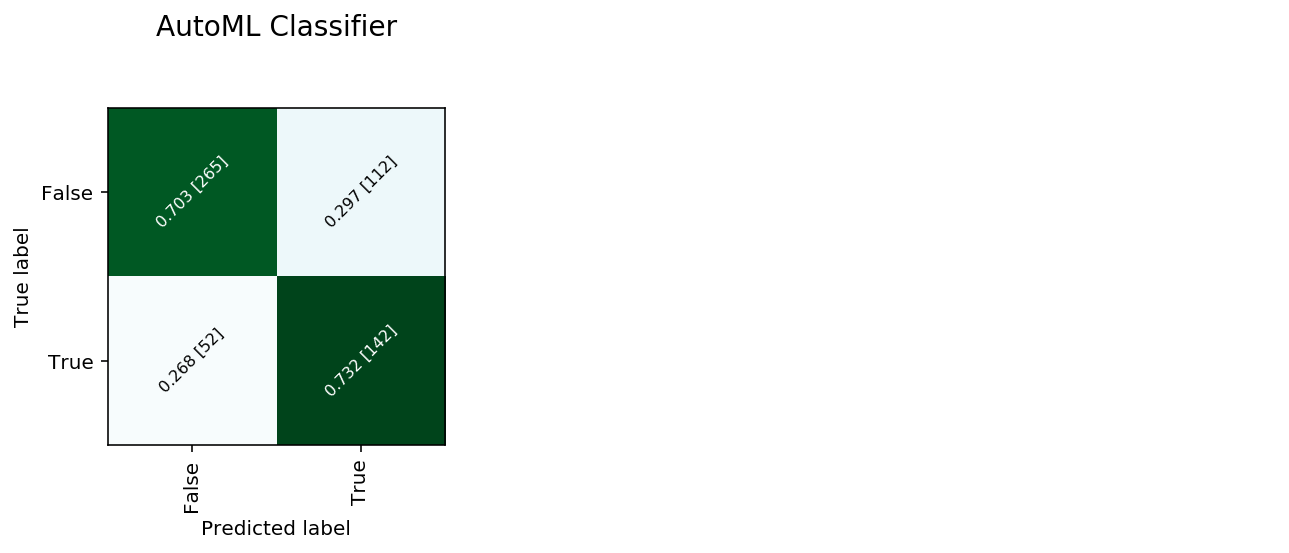

In [189]:
evaluator = ADSEvaluator(test, models=[model])
evaluator.show_in_notebook()

In [30]:
evaluator.metrics

HTML(value='<style  type="text/css" >\n    #T_1efc09b8_2462_11eb_be2f_639482776627  {\n          text-align: r…

In [255]:
# our model explainer class
explainer = ADSExplainer(test, model)

# let's created a global explainer
global_explainer = explainer.global_explanation(provider=MLXGlobalExplainer())

In [256]:
feature_importance = global_explainer.compute_feature_importance() 
feature_importance.show_in_notebook()

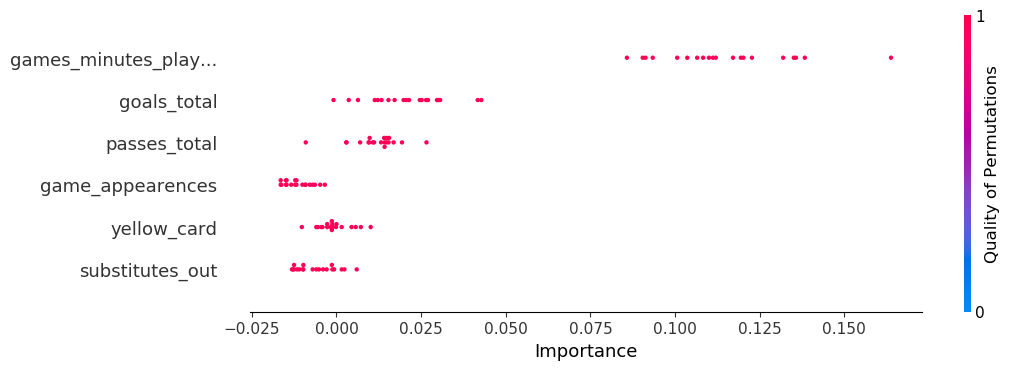

In [257]:
importances.show_in_notebook(n_features=10, mode='detailed')

In [211]:
importances.get_global_explanation()[0]

{'feature': 'games_minutes_played',
 'attribution': 0.1148541022576715,
 'std': 0.018890911827870484,
 'flat_attributions': array([0.13191161, 0.08575452, 0.10061711, 0.11709627, 0.1637624 ,
        0.13568295, 0.11117013, 0.09043266, 0.13504497, 0.10999718,
        0.11940736, 0.09126642, 0.10358963, 0.1201742 , 0.11201431,
        0.13830117, 0.09339172, 0.10827758, 0.12267622, 0.10651364]),
 'flat_qualities': array([0.95004023, 0.97984374, 0.98575273, 0.95075623, 0.95186603,
        0.98170622, 0.92965881, 0.99945261, 0.99431121, 0.98745132,
        0.99018715, 0.97622945, 0.9964771 , 0.95532444, 0.9546232 ,
        0.98548967, 0.98996639, 0.98261528, 0.94234485, 0.99277154])}

In [212]:
importances.get_global_explanation()[3]

{'feature': 'game_appearences',
 'attribution': 0,
 'std': 0.003893218445872963,
 'flat_attributions': array([-0.01219119, -0.00909282, -0.00481066, -0.00927579, -0.003445  ,
        -0.0063604 , -0.01182269, -0.0100692 , -0.01337617, -0.00790771,
        -0.00703772, -0.01492719, -0.01474172, -0.01474172, -0.01647579,
        -0.01492719, -0.01219119, -0.01629427, -0.01647579, -0.01182269]),
 'flat_qualities': array([0.96754805, 0.95526509, 0.99962246, 0.99530634, 0.98235774,
        0.90133157, 0.95761198, 0.92857732, 0.96759325, 0.92551084,
        0.95151546, 0.97374348, 0.93928645, 0.94815272, 0.96628918,
        0.98644007, 0.97028183, 0.94612031, 0.96529108, 0.99554013])}

In [222]:
#global_explainer.partial_dependence_summary()

In [214]:
explanation.show_in_notebook(mode="ice", centered=True, 
                               show_distribution=True, 
                               show_correlation_warning=True, 
                               show_median=True)